### 1. Import Dependencies

In [2]:
import pandas as pd

### 2. Load Dataset

In [ ]:
df = pd.read_csv('groceries.csv', on_bad_lines='skip') # Read the CSV file, skipping bad lines

In [8]:
print("raw df shape:", df.shape)

raw df shape: (6105, 4)


In [9]:
print("raw df columns preview:", list(df.columns)[:10])
display(df.head(10))

raw df columns preview: ['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups']


,citrus fruit,semi-finished bread,margarine,ready soups
0,tropical fruit,yogurt,coffee,NaN
1,whole milk,NaN,NaN,NaN
2,pip fruit,yogurt,cream cheese,meat spreads
3,other vegetables,whole milk,condensed milk,long life bakery product
4,rolls/buns,NaN,NaN,NaN
5,pot plants,NaN,NaN,NaN
6,whole milk,cereals,NaN,NaN
7,beef,NaN,NaN,NaN
8,frankfurter,rolls/buns,soda,NaN
9,chicken,tropical fruit,NaN,NaN


In [10]:
def normalize_item(s):
    return s.strip().lower()

In [13]:
# CASE A: single-column where each row is comma-separated item list
if df.shape[1] == 1:
    print("Detected single-column (one transaction per row). Parsing comma-separated items.")
    transactions = df[0].dropna().astype(str).apply(
        lambda x: [normalize_item(i) for i in x.split(',') if i.strip() != ""]
    ).tolist()
    # CASE B: long format (one item per row) with transaction/customer id columns
else:
    cols = [str(c).lower() for c in df.columns]
    print("Detected multi-column CSV. Columns (lowercased):", cols)
    # try to find common column names
    tx_cols = [c for c in df.columns if any(k in str(c).lower() for k in ['transaction','trans','invoice','order','receipt','id'])]
    cust_cols = [c for c in df.columns if any(k in str(c).lower() for k in ['member','customer','cust','user'])]
    item_cols = [c for c in df.columns if any(k in str(c).lower() for k in ['item','product','description','itemdescription','productdescription'])]
    print("possible tx cols:", tx_cols, "possible customer cols:", cust_cols, "possible item cols:", item_cols)

    if tx_cols and item_cols:
        tx_col = tx_cols[0]
        item_col = item_cols[0]
        grouped = df[[tx_col, item_col]].dropna()
        transactions = grouped.groupby(tx_col)[item_col].apply(
            lambda x: [normalize_item(str(i)) for i in x]
        ).tolist()
    elif cust_cols and 'date' in cols and item_cols:
        # common Kaggle long-format: Member_number, Date, itemDescription
        tx_key = [cust_cols[0], [c for c in df.columns if 'date' in str(c).lower()][0]]
        item_col = item_cols[0]
        grouped = df.groupby([cust_cols[0], tx_key[1]])[item_col].apply(lambda x: [normalize_item(str(i)) for i in x])
        transactions = grouped.tolist()
    else:
        # fallback: try treat each row as transaction by joining all non-null columns
        print("Could not confidently detect transaction structure — falling back to join non-null columns per row.")
        transactions = df.fillna('').astype(str).apply(lambda r: [normalize_item(x) for x in r.tolist() if x.strip()!=''], axis=1).tolist()

Detected multi-column CSV. Columns (lowercased): ['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups']
possible tx cols: [] possible customer cols: [] possible item cols: []
Could not confidently detect transaction structure — falling back to join non-null columns per row.


In [14]:
# final basic clean: remove empty tx and remove duplicates within transaction (presence-only)
from collections import Counter


transactions = [[itm for itm in pd.unique(tx)] for tx in transactions if len(tx) > 0]

# Summaries
n_transactions = len(transactions)
all_items = [i for tx in transactions for i in tx]
unique_items = set(all_items)
freq = Counter(all_items)

print(f"\nParsed transactions: {n_transactions}")
print(f"Unique items (parsed): {len(unique_items)}")
print("Top 20 items by frequency:")



Parsed transactions: 6105
Unique items (parsed): 165
Top 20 items by frequency:


/var/folders/7c/gq0bcsjx4z5518py08krjc880000gn/T/ipykernel_37705/1909183862.py:5: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  transactions = [[itm for itm in pd.unique(tx)] for tx in transactions if len(tx) > 0]


In [ ]:
# Display top 20 items by frequency
for item, cnt in freq.most_common(20):
    print(f"  {item}: {cnt}")

  whole milk: 859
  soda: 773
  rolls/buns: 770
  other vegetables: 531
  canned beer: 502
  bottled water: 406
  bottled beer: 406
  yogurt: 384
  pastry: 308
  newspapers: 296
  shopping bags: 296
  sausage: 294
  tropical fruit: 243
  root vegetables: 227
  citrus fruit: 207
  coffee: 206
  brown bread: 195
  pip fruit: 189
  fruit/vegetable juice: 186
  frankfurter: 176


In [18]:
# Rare items
rare_items = [item for item, c in freq.items() if c == 1]

# show items that apear once by name
print("\nItems that appear exactly once:")
for item in rare_items:
    print(f"  {item}")


Items that appear exactly once:
  salad dressing
  toilet cleaner
  kitchen utensil
  ready soups


In [19]:
# show 5 sample transactions
print("\nSample parsed transactions (first 5):")
for i, tx in enumerate(transactions[:5], 1):
    print(i, tx)


Sample parsed transactions (first 5):
1 ['tropical fruit', 'yogurt', 'coffee']
2 ['whole milk']
3 ['pip fruit', 'yogurt', 'cream cheese', 'meat spreads']
4 ['other vegetables', 'whole milk', 'condensed milk', 'long life bakery product']
5 ['rolls/buns']


### 3. Data Cleaning

In [20]:
# 1. Normalize item names
import re

def normalize_item(name):
    name = name.lower().strip()
    name = re.sub(r'\s+', ' ', name)  # collapse spaces
    name = re.sub(r'[-_]', ' ', name) # replace - and _ with spaces
    # Optional: common corrections
    corrections = {
        'bananas': 'banana',
        'apples': 'apple',
        'milk 1 l': 'milk 1l',
    }
    return corrections.get(name, name)

transactions_cleaned = [
    [normalize_item(item) for item in t] 
    for t in transactions
]

In [21]:
# 2. Drop low-frequency items
from collections import Counter

all_items = [item for t in transactions_cleaned for item in t]
item_counts = Counter(all_items)
min_freq = 3  # keep items appearing at least 3 times
transactions_filtered = [
    [item for item in t if item_counts[item] >= min_freq]
    for t in transactions_cleaned
]

In [22]:
# 3. Remove empty/singleton transactions
transactions_final = [t for t in transactions_filtered if len(t) > 1]

print(f"Transactions before: {len(transactions)}")
print(f"Transactions after cleaning: {len(transactions_final)}")


Transactions before: 6105
Transactions after cleaning: 3946


In [23]:
# Inspect top items after cleaning
from collections import Counter
top_items_after = Counter([i for t in transactions_final for i in t]).most_common(20)
top_items_after

[('whole milk', 738),
 ('rolls/buns', 661),
 ('soda', 617),
 ('other vegetables', 469),
 ('yogurt', 344),
 ('bottled water', 339),
 ('bottled beer', 286),
 ('pastry', 271),
 ('sausage', 270),
 ('shopping bags', 248),
 ('newspapers', 242),
 ('canned beer', 242),
 ('tropical fruit', 220),
 ('root vegetables', 202),
 ('citrus fruit', 191),
 ('brown bread', 175),
 ('coffee', 167),
 ('frankfurter', 165),
 ('fruit/vegetable juice', 164),
 ('pip fruit', 161)]

### 4. Data Transformation

In [24]:
# Get all unique items from cleaned transactions
all_items = sorted({item for tx in transactions_final for item in tx})

# Create a one-hot encoded DataFrame
df_encoded = pd.DataFrame([
    {item: (item in tx) for item in all_items}
    for tx in transactions_final
])

df_encoded.head()

,abrasive cleaner,artif. sweetener,baking powder,bathroom cleaner,beef,berries,beverages,bottled beer,bottled water,brandy,...,uht milk,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### 5. Data Modeling
Apriori Implementation

In [25]:
from itertools import combinations

def apriori(transactions, min_support=0.01):
    """
    transactions: list of lists
    min_support: minimum support threshold (fraction)
    Returns: dict of {itemset: support}
    """
    itemsets = {}
    transaction_count = len(transactions)
    
    # Step 1: single items
    single_items = {frozenset([item]): 0 for tx in transactions for item in tx}
    for tx in transactions:
        for item in tx:
            single_items[frozenset([item])] += 1
    single_items = {i: c / transaction_count for i, c in single_items.items() if c / transaction_count >= min_support}
    itemsets.update(single_items)
    
    # Step 2: larger itemsets
    current_itemsets = single_items
    k = 2
    while current_itemsets:
        candidates = {frozenset(x) for a in current_itemsets.keys() for b in current_itemsets.keys() for x in [a | b] if len(x) == k}
        counts = {c: 0 for c in candidates}
        for tx in transactions:
            tx_set = set(tx)
            for c in candidates:
                if c.issubset(tx_set):
                    counts[c] += 1
        current_itemsets = {c: count / transaction_count for c, count in counts.items() if count / transaction_count >= min_support}
        itemsets.update(current_itemsets)
        k += 1
    return itemsets

# Run Apriori
frequent_itemsets = apriori(transactions_final, min_support=0.01)

# Sort by support
frequent_itemsets_sorted = sorted(frequent_itemsets.items(), key=lambda x: x[1], reverse=True)

print("Top 10 frequent itemsets:")
for items, support in frequent_itemsets_sorted[:10]:
    print(list(items), f"support={support:.3f}")

Top 10 frequent itemsets:
['whole milk'] support=0.187
['rolls/buns'] support=0.168
['soda'] support=0.156
['other vegetables'] support=0.119
['yogurt'] support=0.087
['bottled water'] support=0.086
['bottled beer'] support=0.072
['pastry'] support=0.069
['sausage'] support=0.068
['shopping bags'] support=0.063


### 6. Association Rules

In [26]:
def generate_rules(frequent_itemsets, min_confidence=0.2):
    """
    frequent_itemsets: dict of {itemset: support}
    Returns: list of dicts with keys: antecedent, consequent, support, confidence, lift
    """
    rules = []
    for itemset, support in frequent_itemsets.items():
        if len(itemset) < 2:
            continue
        for i in range(1, len(itemset)):
            for antecedent in combinations(itemset, i):
                antecedent = frozenset(antecedent)
                consequent = itemset - antecedent
                if not consequent:
                    continue
                support_a = frequent_itemsets.get(antecedent, 0)
                support_c = frequent_itemsets.get(consequent, 0)
                if support_a == 0:
                    continue
                confidence = support / support_a
                lift = confidence / support_c if support_c > 0 else 0
                if confidence >= min_confidence:
                    rules.append({
                        "antecedent": tuple(sorted(antecedent)),
                        "consequent": tuple(sorted(consequent)),
                        "support": support,
                        "confidence": confidence,
                        "lift": lift
                    })
    return sorted(rules, key=lambda x: x["lift"], reverse=True)

rules = generate_rules(frequent_itemsets, min_confidence=0.2)

print("Top 10 association rules:")
for r in rules[:10]:
    print(f"{r['antecedent']} => {r['consequent']} "
          f"(support={r['support']:.3f}, confidence={r['confidence']:.3f}, lift={r['lift']:.3f})")

Top 10 association rules:
('root vegetables',) => ('other vegetables',) (support=0.012, confidence=0.228, lift=1.916)
('sausage',) => ('rolls/buns',) (support=0.021, confidence=0.304, lift=1.813)
('frankfurter',) => ('rolls/buns',) (support=0.013, confidence=0.303, lift=1.809)
('root vegetables',) => ('whole milk',) (support=0.012, confidence=0.238, lift=1.271)
('newspapers',) => ('whole milk',) (support=0.012, confidence=0.202, lift=1.083)


### 7. Filtering Rules

In [27]:
target_product = "whole milk"

rules_for_target = [
    r for r in rules
    if target_product in r["consequent"]
]

print(f"Rules that predict '{target_product}':")
for r in rules_for_target[:10]:
    print(f"{r['antecedent']} => {r['consequent']} "
          f"(support={r['support']:.3f}, confidence={r['confidence']:.3f}, lift={r['lift']:.3f})")

Rules that predict 'whole milk':
('root vegetables',) => ('whole milk',) (support=0.012, confidence=0.238, lift=1.271)
('newspapers',) => ('whole milk',) (support=0.012, confidence=0.202, lift=1.083)


### 8. Saving Association Rule

In [28]:
pd.DataFrame([
    {"items": list(items), "support": support}
    for items, support in frequent_itemsets.items()
]).to_csv("frequent_itemsets.csv", index=False)

pd.DataFrame(rules).to_csv("association_rules.csv", index=False)

Transactions: 3946
Unique items: 156
Top 15 items: [('whole milk', 738), ('rolls/buns', 661), ('soda', 617), ('other vegetables', 469), ('yogurt', 344), ('bottled water', 339), ('bottled beer', 286), ('pastry', 271), ('sausage', 270), ('shopping bags', 248), ('newspapers', 242), ('canned beer', 242), ('tropical fruit', 220), ('root vegetables', 202), ('citrus fruit', 191)]


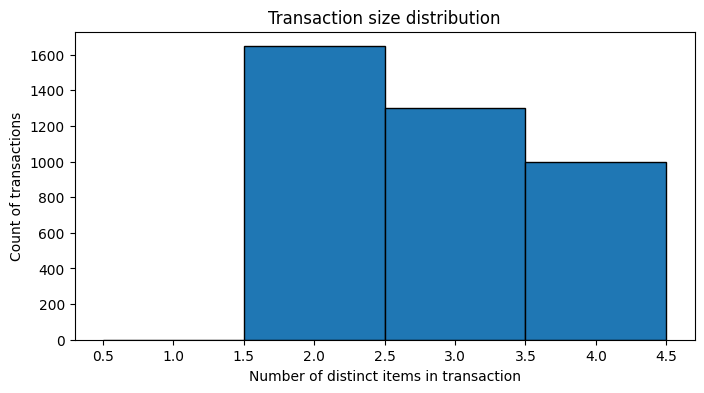

In [29]:
# Cell 1: Basic stats & distribution
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

n_tx = len(transactions_final)
all_items = [itm for tx in transactions_final for itm in tx]
unique_items = sorted(set(all_items))
item_counts = Counter(all_items)

print(f"Transactions: {n_tx}")
print(f"Unique items: {len(unique_items)}")
print("Top 15 items:", item_counts.most_common(15))

# Transaction length distribution
tx_lengths = [len(tx) for tx in transactions_final]
plt.figure(figsize=(8,4))
plt.hist(tx_lengths, bins=range(1, max(tx_lengths)+2), edgecolor='k', align='left')
plt.title("Transaction size distribution")
plt.xlabel("Number of distinct items in transaction")
plt.ylabel("Count of transactions")
plt.show()

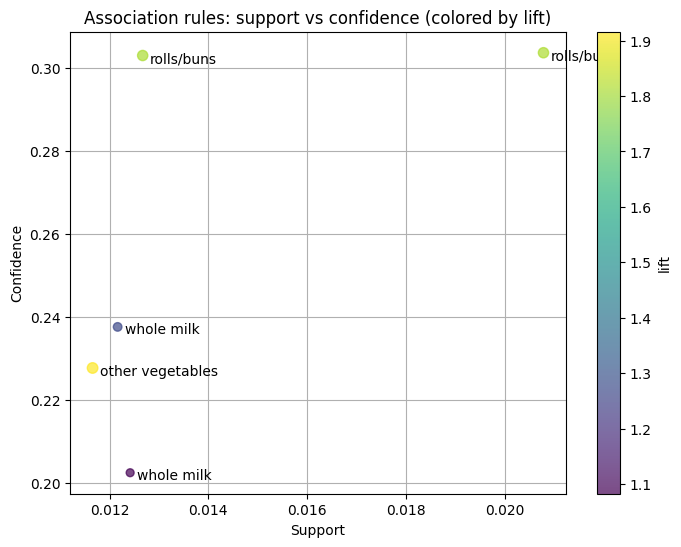

In [30]:
# Cell 5: scatter plot support vs confidence, color by lift
import matplotlib.pyplot as plt
import numpy as np

s = [r['support'] for r in rules]
c = [r['confidence'] for r in rules]
l = [r['lift'] for r in rules]

plt.figure(figsize=(8,6))
sc = plt.scatter(s, c, c=l, cmap='viridis', s=np.array(l)*30, alpha=0.7)
plt.colorbar(sc, label='lift')
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.title("Association rules: support vs confidence (colored by lift)")
plt.grid(True)

# annotate top lifts
top_lift_rules = sorted(rules, key=lambda r: r['lift'], reverse=True)[:6]
for r in top_lift_rules:
    plt.annotate(','.join(list(r['consequent'])), (r['support'], r['confidence']), textcoords="offset points", xytext=(5,-5))

plt.show()

In [32]:
%pip install networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 1.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


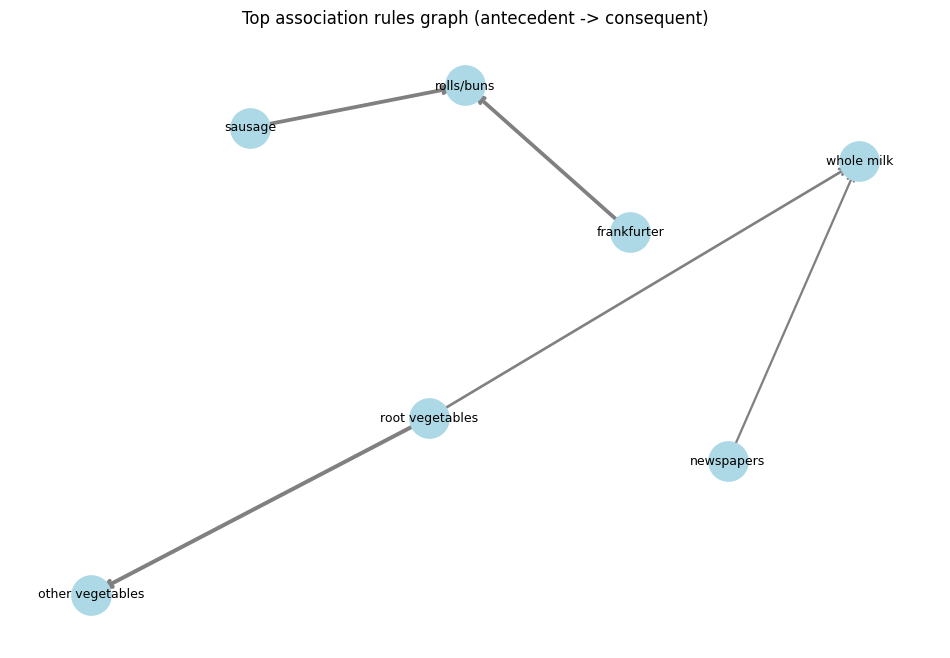

In [33]:
# Cell 6: network graph of top rules (attempt networkx; otherwise skip)
try:
    import networkx as nx
    top_k = 30
    G = nx.DiGraph()
    selected = rules[:top_k]
    for r in selected:
        a = ', '.join(sorted(list(r['antecedent'])))
        b = ', '.join(sorted(list(r['consequent'])))
        G.add_node(a)
        G.add_node(b)
        G.add_edge(a, b, weight=r['lift'], support=r['support'], confidence=r['confidence'])
    plt.figure(figsize=(12,8))
    pos = nx.spring_layout(G, k=1.0)
    weights = [G[u][v]['weight'] for u,v in G.edges()]
    nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, font_size=9)
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=12, width=[(w*1.5) for w in weights], edge_color='gray')
    plt.title("Top association rules graph (antecedent -> consequent)")
    plt.axis('off')
    plt.show()
except Exception as e:
    print("networkx visualization skipped (not installed or error).", e)

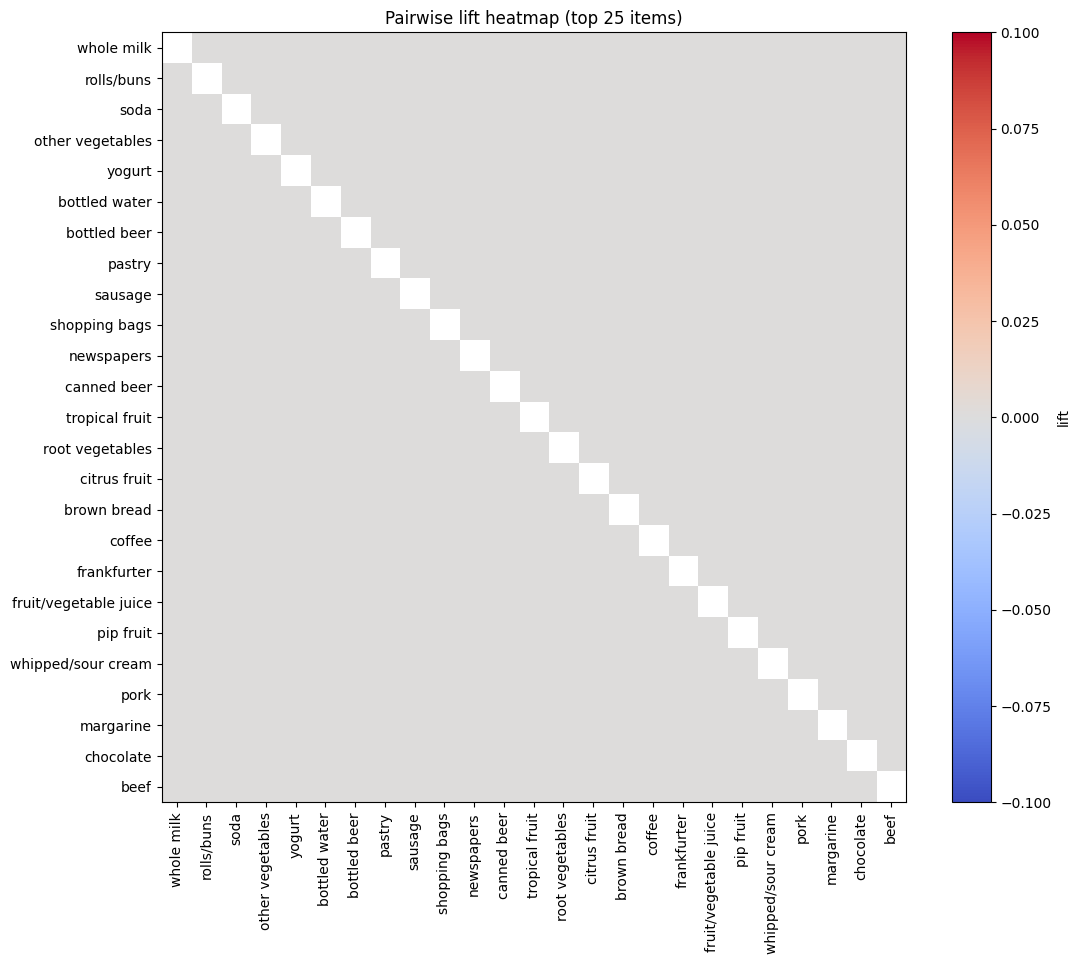

In [36]:
# Cell 7: pairwise lift heatmap for top N items
import numpy as np
import matplotlib.pyplot as plt

# compute support dict for singletons
support = {it: frequent_itemsets.get(frozenset([it]), 0) for it in unique_items}
top_n = 25
top_items = [it for it,_ in item_counts.most_common(top_n)]

# compute pairwise lift matrix
lift_matrix = np.zeros((len(top_items), len(top_items)))
for i, a in enumerate(top_items):
    for j, b in enumerate(top_items):
        if a == b:
            lift_matrix[i,j] = np.nan
            continue
        sup_ab = frequent_itemsets.get(frozenset([a,b]), 0)
        sup_a = support.get(a, 0)
        sup_b = support.get(b, 0)
        if sup_a*sup_b != sup_a*sup_b:
            lift = (sup_ab / (sup_a*sup_b)) if sup_a>0 and sup_b>0 else 0
        else:
            lift = 0
        lift_matrix[i,j] = lift

plt.figure(figsize=(12,10))
plt.imshow(lift_matrix, aspect='auto', cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='lift')
plt.xticks(range(len(top_items)), top_items, rotation=90)
plt.yticks(range(len(top_items)), top_items)
plt.title(f"Pairwise lift heatmap (top {top_n} items)")
plt.show()

In [37]:
den = sup_a * sup_b
if den > 0:
    lift = sup_ab / den
else:
    lift = 0

In [39]:
%pip install mlxtend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 1.7 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [40]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import pandas as pd

def apriori_itemsets(transactions, min_support=0.01):
    """
    Mine frequent itemsets using the Apriori algorithm.
    
    Parameters:
        transactions (list of list of str): List of baskets, each a list of items.
        min_support (float): Minimum support threshold.
        
    Returns:
        DataFrame: Frequent itemsets with 'support'.
    """
    # Create a one-hot encoded DataFrame for transactions
    df = pd.DataFrame([{item: True for item in basket} for basket in transactions]).fillna(False)
    
    # Run Apriori
    frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
    
    return frequent_itemsets

# Example usage:
train_tx = [
    ['milk', 'bread', 'butter'],
    ['milk', 'bread'],
    ['milk', 'butter'],
    ['bread', 'butter'],
    ['milk', 'bread', 'butter']
]

min_support = 0.5
freq_train = apriori_itemsets(train_tx, min_support=min_support)
print(freq_train)

   support         itemsets
0      0.8           (milk)
1      0.8          (bread)
2      0.8         (butter)
3      0.6    (milk, bread)
4      0.6   (milk, butter)
5      0.6  (bread, butter)


/var/folders/7c/gq0bcsjx4z5518py08krjc880000gn/T/ipykernel_37705/3702881234.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = pd.DataFrame([{item: True for item in basket} for basket in transactions]).fillna(False)


In [44]:
# Cell 8: Evaluate rules by train/test split (simple holdout)
from random import shuffle, seed
seed(42)

def train_test_split(transactions, test_frac=0.2):
    tx = transactions.copy()
    shuffle(tx)
    split = int(len(tx)*(1-test_frac))
    return tx[:split], tx[split:]

train_tx, test_tx = train_test_split(transactions_final, test_frac=0.2)
print("train:", len(train_tx), "test:", len(test_tx))

# Mine itemsets on train
min_confidence = 0.5
freq_train = apriori_itemsets(train_tx, min_support=min_support)
rules_train = generate_rules(freq_train, min_confidence=min_confidence)
print("Rules on train:", len(rules_train))

# Evaluate: for each test transaction, for each antecedent subset present, check if predicted consequent is in test tx
def evaluate_rules(rules, test_transactions, top_k=None):
    # build a mapping antecedent -> list of consequents ordered by lift
    from collections import defaultdict
    mapping = defaultdict(list)
    for r in rules:
        mapping[tuple(sorted(r['antecedent']))].append(r)
    # sort each antecedent's consequents by lift desc
    for k,v in mapping.items():
        mapping[k] = sorted(v, key=lambda x: x['lift'], reverse=True)
    # metrics
    total_preds = 0
    correct = 0
    for tx in test_transactions:
        tx_set = set(tx)
        # for each antecedent present in the tx
        for antecedent in mapping.keys():
            if set(antecedent).issubset(tx_set):
                # recommend top consequent(s) (we'll take top 1 for simplicity)
                preds = mapping[antecedent][:1]
                for p in preds:
                    total_preds += 1
                    if set(p['consequent']).issubset(tx_set):
                        correct += 1
    precision = correct / total_preds if total_preds>0 else None
    return {'total_preds': total_preds, 'correct': correct, 'precision': precision}

eval_res = evaluate_rules(rules_train, test_tx)
print("Evaluation (precision of top-1 consequent):", eval_res)

train: 3156 test: 790
Rules on train: 0
Evaluation (precision of top-1 consequent): {'total_preds': 0, 'correct': 0, 'precision': None}


In [43]:
from collections import defaultdict
from itertools import combinations

def apriori_itemsets(transactions, min_support=0.01):
    # total number of transactions
    n_transactions = len(transactions)
    min_count = int(min_support * n_transactions)
    
    # Step 1: count individual items
    item_counts = defaultdict(int)
    for tx in transactions:
        for item in tx:
            item_counts[frozenset([item])] += 1
    
    # Keep items that meet min_support
    freq_itemsets = {item: count for item, count in item_counts.items() if count >= min_count}
    all_freq_itemsets = dict(freq_itemsets)  # copy for final output
    
    k = 2
    current_freq_items = list(freq_itemsets.keys())
    
    while current_freq_items:
        candidates = set()
        for i in range(len(current_freq_items)):
            for j in range(i+1, len(current_freq_items)):
                union_set = current_freq_items[i] | current_freq_items[j]
                if len(union_set) == k:
                    candidates.add(union_set)
        
        # Count candidates
        candidate_counts = defaultdict(int)
        for tx in transactions:
            tx_set = set(tx)
            for cand in candidates:
                if cand.issubset(tx_set):
                    candidate_counts[cand] += 1
        
        # Keep those meeting min_support
        current_freq_items = [itemset for itemset, count in candidate_counts.items() if count >= min_count]
        freq_k_itemsets = {itemset: candidate_counts[itemset] for itemset in current_freq_items}
        
        # Add to all frequent itemsets
        all_freq_itemsets.update(freq_k_itemsets)
        
        k += 1
    
    # Convert counts to supports
    freq_with_support = {itemset: count / n_transactions for itemset, count in all_freq_itemsets.items()}
    
    return freq_with_support

In [45]:
# Cell 9: simple recommend function using mined rules
def recommend_for_basket(basket, rules, top_n=5):
    basket_set = set(basket)
    candidates = {}
    for r in rules:
        if r['antecedent'].issubset(basket_set):
            conj = tuple(sorted(r['consequent']))
            # score by lift * confidence * support (arbitrary scoring to rank)
            score = r['lift'] * r['confidence'] * r['support']
            candidates[conj] = max(candidates.get(conj, 0), score)
    # return top_n sorted
    out = sorted(candidates.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return [(list(k), v) for k,v in out]

# Example test
basket = ["whole milk", "brown bread"]
print("Basket:", basket)
print("Recommendations:", recommend_for_basket(basket, rules))

Basket: ['whole milk', 'brown bread']


AttributeError: 'tuple' object has no attribute 'issubset'

In [46]:
# Cell 10: Export top K rules as human readable CSV + print summary
import pandas as pd
top_k = 50
records = []
for r in rules[:top_k]:
    records.append({
        'antecedent': ';'.join(sorted(list(r['antecedent']))),
        'consequent': ';'.join(sorted(list(r['consequent']))),
        'support': r['support'],
        'confidence': r['confidence'],
        'lift': r['lift']
    })
df_rules = pd.DataFrame(records)
df_rules.to_csv("top_association_rules.csv", index=False)
print("Exported top rules to top_association_rules.csv")
df_rules.head(20)

Exported top rules to top_association_rules.csv


,antecedent,consequent,support,confidence,lift
0,root vegetables,other vegetables,0.011657,0.227723,1.915979
1,sausage,rolls/buns,0.020781,0.303704,1.813033
2,frankfurter,rolls/buns,0.012671,0.303030,1.809013
3,root vegetables,whole milk,0.012164,0.237624,1.270547
4,newspapers,whole milk,0.012418,0.202479,1.082633


In [47]:
test_baskets = [
    ["whole milk", "brown bread"],
    ["yogurt", "tropical fruit"],
    ["soda", "chips"],
    ["domestic eggs", "bottled water"],
]

for b in test_baskets:
    print(f"\nBasket: {b}")
    recs = recommend_for_basket(b, rules)
    for items, score in recs:
        print(f"  Recommend: {items} (score: {score:.4f})")


Basket: ['whole milk', 'brown bread']


AttributeError: 'tuple' object has no attribute 'issubset'

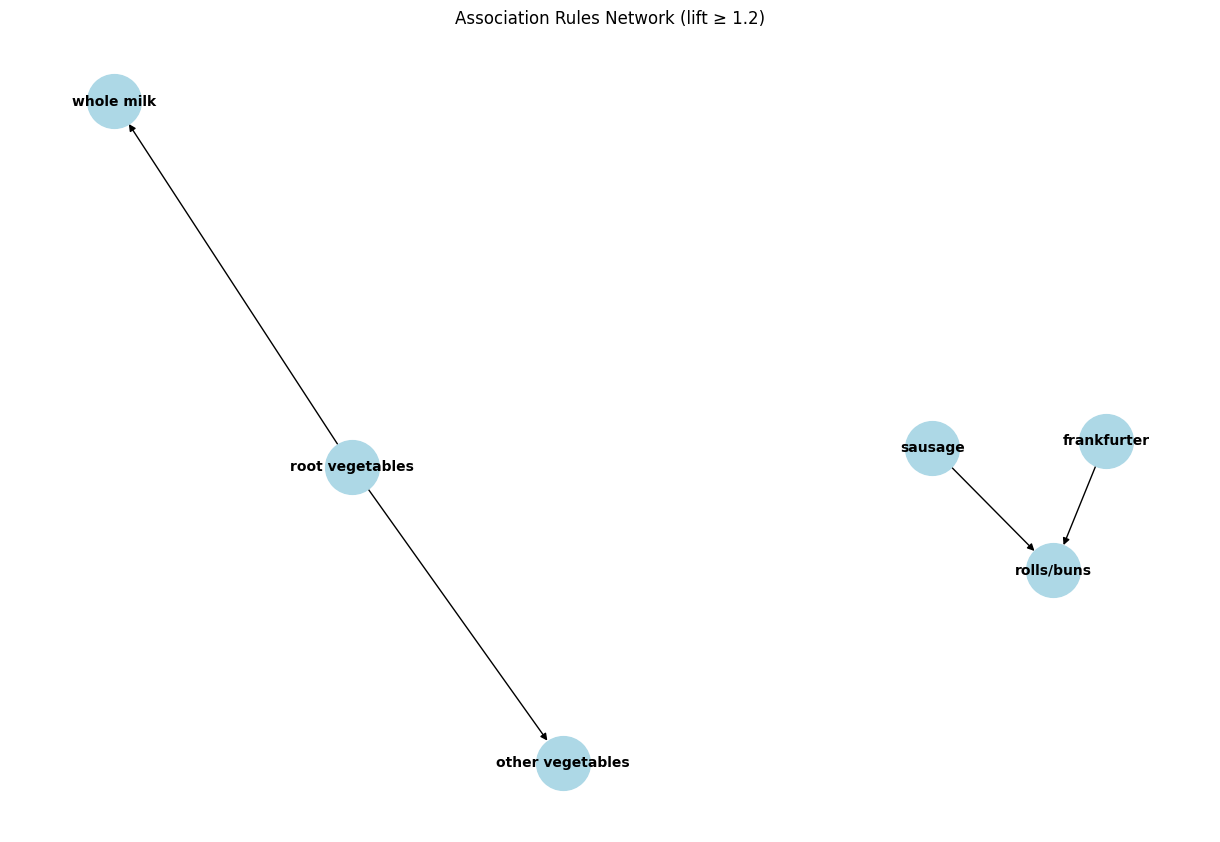

In [48]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_rules(rules, min_lift=1.2):
    G = nx.DiGraph()
    for r in rules:
        if r['lift'] >= min_lift:
            for ant in r['antecedent']:
                for cons in r['consequent']:
                    G.add_edge(ant, cons, weight=r['lift'])
    pos = nx.spring_layout(G, k=0.5)
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_size=1500, node_color='lightblue', font_size=10, font_weight='bold')
    plt.title("Association Rules Network (lift ≥ {:.1f})".format(min_lift))
    plt.show()

plot_rules(rules)

In [49]:
def evaluate_rules(transactions, rules, top_n=5):
    hits, total, covered = 0, 0, 0
    for t in transactions:
        total += 1
        recs = recommend_for_basket(t, rules, top_n)
        if recs:
            covered += 1
            rec_items = {i for items, _ in recs for i in items}
            if rec_items & set(t):
                hits += 1
    return {
        "Coverage": covered / total,
        "Hit Rate": hits / covered if covered else 0
    }

metrics = evaluate_rules(transactions, rules)
print(metrics)

AttributeError: 'tuple' object has no attribute 'issubset'

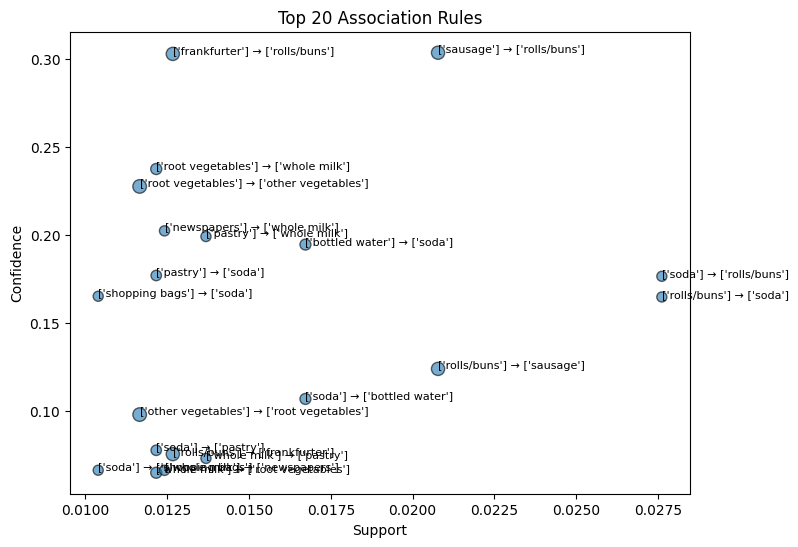

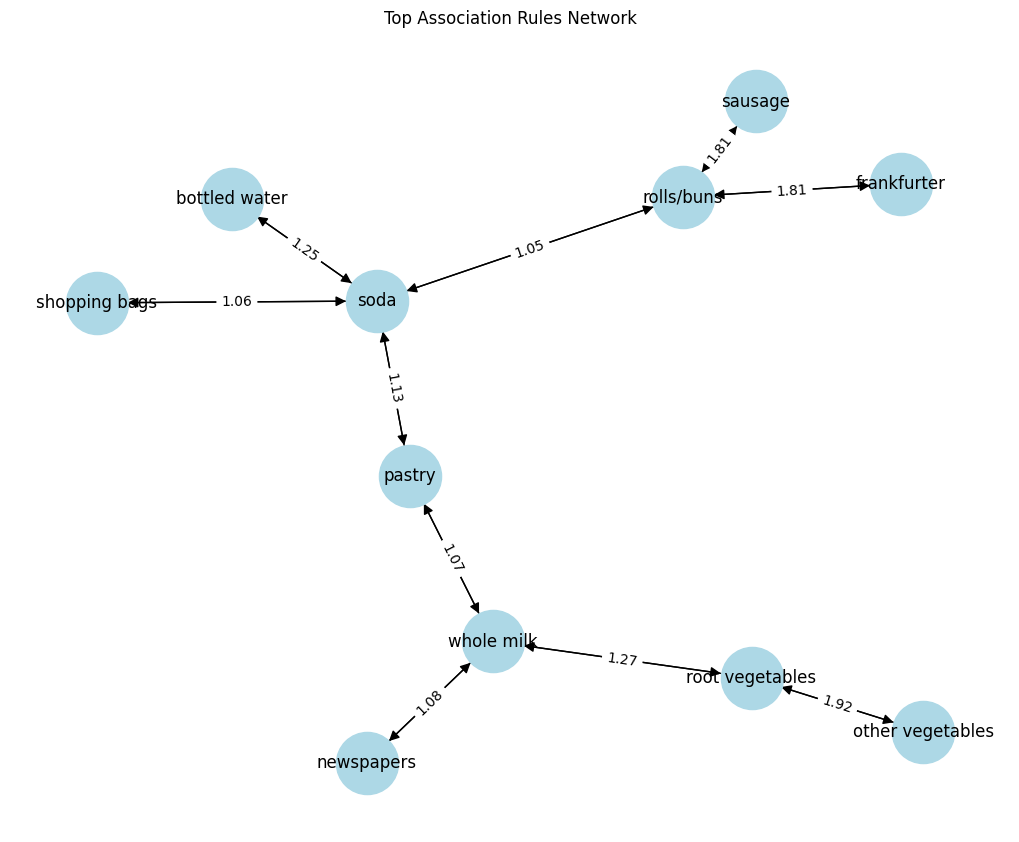

Basket: ['whole milk', 'brown bread']
Recommendations: [(['other vegetables'], 0.002759843487052179), (['pastry'], 0.0010668399366920494), (['root vegetables'], 0.0010052165240319393), (['newspapers'], 0.0008926067166111873)]


In [50]:
# Install mlxtend if not available
# pip install mlxtend

import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import networkx as nx

# -----------------------
# 1. Load and prepare data
# -----------------------
# Example CSV: transactions in one-hot encoded format
#df = pd.read_csv("groceries_encoded.csv")  # Ensure one-hot format

# -----------------------
# 2. Train model (Apriori)
# -----------------------
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)
rules_df = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# -----------------------
# 3. Visualize Top Rules
# -----------------------
top_rules = rules_df.sort_values("lift", ascending=False).head(20)

plt.figure(figsize=(8,6))
plt.scatter(top_rules['support'], top_rules['confidence'],
            s=top_rules['lift']*50, alpha=0.6, edgecolors="k")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.title("Top 20 Association Rules")
for i, rule in top_rules.iterrows():
    plt.text(rule['support'], rule['confidence'],
             f"{list(rule['antecedents'])} → {list(rule['consequents'])}", fontsize=8)
plt.show()

# -----------------------
# 4. Network Graph
# -----------------------
G = nx.DiGraph()
for _, row in top_rules.iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            G.add_edge(a, c, weight=row['lift'])

plt.figure(figsize=(10,8))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", arrowsize=15)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k,v in labels.items()})
plt.title("Top Association Rules Network")
plt.show()

# -----------------------
# 5. Simple Recommendation Function
# -----------------------
def recommend_for_basket(basket, rules, top_n=5):
    basket_set = set(basket)
    candidates = {}
    for _, r in rules.iterrows():
        if r['antecedents'].issubset(basket_set):
            conj = tuple(sorted(r['consequents']))
            score = r['lift'] * r['confidence'] * r['support']
            candidates[conj] = max(candidates.get(conj, 0), score)
    out = sorted(candidates.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return [(list(k), v) for k, v in out]

# -----------------------
# 6. Test Example Basket
# -----------------------
basket = ["whole milk", "brown bread"]
recommendations = recommend_for_basket(basket, rules_df)
print("Basket:", basket)
print("Recommendations:", recommendations)